In [5]:
import pysam
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
import copy
import random
from Bio import SeqIO

### extract Hi-C link count data and coverage info from bam files

In [6]:
def extract_links(bam_file):
    """
    Function to be applied to file after matlock filtering, no unaligned reads should be present.
    Takes a bam file as input and returns the counts for the links present.
    """
    print('Starting ', bam_file)
    samfile = pysam.AlignmentFile(bam_file, 'rb')
    count = 0
    genomes = {'pB10::rfp_putative':'pB10', 'NC_002947.4':'P.Putida', 'NC_000913.3_gfp':'E.Coli'}
    pB10_pB10 = 0
    pB10_ecoli = 0
    pB10_pputida = 0
    ecoli_ecoli = 0
    pputida_pputida = 0
    multimapped = 0
    pairs = []
    
    #ecoli_file = open('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/'+bam_file+'ecoli_pb10_chromosome.fasta','w')
    #pputida_file = open('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/'+bam_file+'pputida_pb10_chromosome.fasta','w')
    
    #lists that store the location on the pB10 genome of each aligned read
    pB10_pB10_loc = []
    pB10_pputida_loc = []
    pB10_ecoli_loc = []
    
    #lists that store location on chromosome of pb10 aligned reads
    ecoli_pB10_loc = []
    pputida_pB10_loc = []
    
    global p_putida
    global p_p
    global p_ecoli
    p_putida = [0]*pb10_len
    p_p = [0]*pb10_len
    p_ecoli = [0]*pb10_len
    
    for read in samfile.fetch(until_eof=True):
        count += 1
        genome = ''
        name = ''
        cigar = ''
        loc = ''
        seq = read.query_sequence
        length = len(seq)
        if read.is_unmapped:
            name = read.query_name
            genome = 'unaligned'
        if not read.is_unmapped:
            name = read.query_name
            genome = genomes.get(read.reference_name)
            cigar = read.cigarstring
            match = str(length)+'M'
            loc = read.reference_start
            if cigar != match:
                genome='unaligned'
        pairs.append([name, genome, loc, length, read.get_tags(), read.query_sequence])
        if count % 2 == 0:
            r1_multimapped = check_alt(pairs[0][1], pairs[0][4], pairs[0][3])
            r2_multimapped = check_alt(pairs[1][1], pairs[1][4], pairs[1][3])
            if len(r1_multimapped) > 1 or len(r2_multimapped) >1:
                multimapped += 1
                pairs = []
            else:
                links = pairs[0][1] + pairs[1][1]
                if links == 'pB10pB10':
                    pB10_pB10 += 1
                    update_counts('plasmid','plasmid', [pairs[0][2], pairs[1][2]], [pairs[0][3], pairs[1][3]])
                    pB10_pB10_loc.append(pairs[0][2])
                    pB10_pB10_loc.append(pairs[1][2])
                if links == 'pB10P.Putida':
                    pB10_pputida += 1
                    update_counts('plasmid', 'putida', pairs[0][2], pairs[0][3])
                    pB10_pputida_loc.append(pairs[0][2])
                    pputida_pB10_loc.append(pairs[1][2])
                    #pputida_file.write(">" + pairs[1][0] + '\n' + pairs[1][-1] + '\n')
                if links == 'P.PutidapB10':
                    pB10_pputida += 1
                    update_counts('putida', 'plasmid', pairs[1][2], pairs[1][3])
                    pB10_pputida_loc.append(pairs[1][2])
                    pputida_pB10_loc.append(pairs[0][2])
                    #pputida_file.write(">" + pairs[0][0] + '\n' + pairs[0][-1] + '\n')
                if links == 'pB10E.Coli':
                    pB10_ecoli += 1
                    update_counts('plasmid', 'ecoli', pairs[0][2], pairs[0][3])
                    pB10_ecoli_loc.append(pairs[0][2])
                    ecoli_pB10_loc.append(pairs[1][2])
                    #ecoli_file.write(">" + pairs[1][0] + '\n' + pairs[1][-1] + '\n')
                if links == 'E.ColipB10':
                    pB10_ecoli += 1
                    update_counts('ecoli', 'plasmid', pairs[1][2], pairs[1][3])
                    pB10_ecoli_loc.append(pairs[1][2])
                    ecoli_pB10_loc.append(pairs[1][2])
                    #ecoli_file.write(">" + pairs[0][0] + '\n' + pairs[0][-1] + '\n')
                if links == 'E.ColiE.Coli':
                    ecoli_ecoli += 1 
                if links == 'P.PutidaP.Putida':
                    pputida_pputida += 1
                pairs = []
    print(np.array([count/2, multimapped, pB10_pB10, pB10_ecoli, pB10_pputida], '\n'))
    print('\n')
    return(np.array([[count/2, multimapped, pB10_pB10, pB10_ecoli, pB10_pputida],
                    [p_putida, p_p, p_ecoli], 
                    [pB10_pputida_loc, pB10_pB10_loc, pB10_ecoli_loc, ecoli_pB10_loc, pputida_pB10_loc]]))

def update_counts(ref, link, start_index, length):
    """Function for updating the coverage list"""
    global p_putida
    global p_ecoli
    global p_p
    
    if ref == 'plasmid':
        if link == 'ecoli':
            s = start_index
            e = start_index + length
            for i in range(s, e):
                if i < pb10_len:
                    p_ecoli[i] += 1
                else:
                    i = i - pb10_len
                    p_ecoli[i] += 1 
        if link == 'putida':
            s = start_index
            e = start_index + length
            for i in range(s, e):
                if i < pb10_len:
                    p_putida[i] += 1
                else:
                    i = i - pb10_len
                    p_putida[i] += 1 
        

    if link == 'plasmid':
        if ref == 'ecoli':
            s = start_index
            e = start_index + length
            for i in range(s, e):
                if i < pb10_len:
                    p_ecoli[i] += 1
                else:
                    i = i - pb10_len
                    p_ecoli[i] += 1 
        if ref == 'putida':
            s = start_index
            e = start_index + length
            for i in range(s, e):
                if i < pb10_len:
                    p_putida[i] += 1
                else:
                    i = i - pb10_len
                    p_putida[i] += 1 
                    
    if ref == 'plasmid' and link == 'plasmid':                  
        for i in range(0,2):
            s = start_index[i]
            e = start_index[i] + length[i]
            for i in range(s, e):
                if i < pb10_len:
                    p_p[i] += 1
                else:
                    i = i - pb10_len
                    p_p[i] += 1
                    
def check_alt(aligned, tags, length):
    """
    This function uses the alignment tags to determine if a read was
    mapped perfectly to multiple references. The output is a list of 
    references to which the read mapped.
    """
    genomes = [aligned]
    for tag in tags:
        if tag[0] == 'XA' or tag[0] == 'SA':
            tag = list(tag)
            others = tag[1].split(';')[:-1]
            fmatch = []
            for alt in others:
                info = alt.split(',')
                if info[-2] == str(length)+'M':
                    fmatch.append(info[0])
            for i in fmatch:
                genomes.append(i)
    return(list(set(genomes)))

In [76]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/05_bwa_alignment/filtered/')

pb10_len = 68345
p_p = [0]*pb10_len
p_ecoli = [0]*pb10_len
p_putida = [0]*pb10_len

#A_all = extract_links('B.bam')
#B_all = extract_links('C.bam')
#C_all = extract_links('D.bam')
#D_all = extract_links('E.bam')
#E_all = extract_links('F.bam')
#ctrl1_all = extract_links('ctrl1_ecoli.bam')
#
Bplus_all = extract_links('C+.bam')
Cplus_all = extract_links('D+.bam')
Dplus_all = extract_links('E+.bam')
Eplus_all = extract_links('F+.bam')
Fplus_all = extract_links('G+.bam')
#ctrl1plus_all = extract_links('ctrl1+_ecoli.bam')
#ctrl2plus_all = extract_links('ctrl2+_soil.bam')

Starting  C+.bam
[60659869  3958050 25308611   390326   175393]


Starting  D+.bam
[309298074  21234014 118464211   3071121    124117]


Starting  E+.bam
[42350206  3411471 15182320   797366     4636]


Starting  F+.bam
[66131497  5235376 22108541  1148537      161]


Starting  G+.bam
[297184008  22228771 103264350   6401289       872]




In [77]:
#get sequencing depth for each library from multiqc report
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/02_fastqc/untrimmed/multiqc_data/')
seq_depth = pd.read_csv('multiqc_general_stats.txt', sep='\t')
seq_depth = seq_depth[['Sample', 'FastQC_mqc-generalstats-fastqc-total_sequences']]
seq_depth.rename(columns={'FastQC_mqc-generalstats-fastqc-total_sequences':'num_reads'}, inplace=True)
seq_depth = seq_depth.iloc[::2]
seq_depth['Sample'] = seq_depth.Sample.str[:-3]
seq_depth.reset_index(inplace=True)
seq_depth.drop(columns=['index'], inplace=True)
seq_depth['Type'] = ['Hi-C', 'Hi-C+', 'Hi-C', 'Hi-C+', 'Hi-C', 'Hi-C+', 'Hi-C', 'Hi-C+', 'Hi-C', 'Hi-C+', 'Hi-C+', 'Hi-C', 'Hi-C+']
seq_depth['Sample'] = ['A', 'B', 'B', 'C', 'C', 'D', 'D', 'E', 'E', 'F', 'Ctrl1', 'Ctrl1', 'Ctrl2']
seq_depth

,Sample,num_reads,Type
0,A,102818926.0,Hi-C
1,B,67166513.0,Hi-C+
2,B,97688195.0,Hi-C
3,C,466371775.0,Hi-C+
4,C,155702732.0,Hi-C
5,D,56882152.0,Hi-C+
6,D,127023749.0,Hi-C
7,E,83617103.0,Hi-C+
8,E,146798824.0,Hi-C
9,F,405252012.0,Hi-C+


In [920]:
#place hic-data into dataframe, output two csv files
#first is raw counts and second is normalized per million counts
hic_all = pd.DataFrame([A_all[0], B_all[0], C_all[0], D_all[0], E_all[0], ctrl1_all[0]],
                     columns = ['count', 'multimapped', 'pB10_pB10','pB10_ecoli','pB10_pputida'])
hic_all['Sample'] = ['A', 'B', 'C', 'D', 'E', 'Ctrl1']
hic_all = hic_all.merge(seq_depth[seq_depth['Type']=='Hi-C']).drop(['count', 'Type'], axis=1)
hic_all.set_index("Sample", inplace=True)
hic_all.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/hic_counts_raw.csv')

hic_all['standard'] = seq_depth['num_reads'].min()/hic_all['num_reads']
hic_all.drop(columns='num_reads', inplace=True)

#normalize hic counts
hic_all['pB10_pB10'] = hic_all['pB10_pB10']*hic_all['standard']
hic_all['pB10_ecoli'] = hic_all['pB10_ecoli']*hic_all['standard']
hic_all['pB10_pputida'] = hic_all['pB10_pputida']*hic_all['standard']

hic_all.drop(columns='standard', inplace=True)
hic_all.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/hic_counts_normalized.csv')

#place hic+-data into dataframe, output two csv files
#first is raw counts and second is normalized per million counts
hicplus_all = pd.DataFrame([Bplus_all[0], Cplus_all[0], Dplus_all[0], Eplus_all[0], Fplus_all[0], ctrl1plus_all[0], ctrl2plus_all[0]],
                     columns = ['count', 'multimapped', 'pB10_pB10','pB10_ecoli','pB10_pputida'])
hicplus_all['Sample'] = ['B', 'C', 'D', 'E', 'F', 'Ctrl1', 'Ctrl2']
hicplus_all = hicplus_all.merge(seq_depth[seq_depth['Type']=='Hi-C+']).drop(['count', 'Type'], axis=1)
hicplus_all.set_index("Sample", inplace=True)
hicplus_all.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/hic+_counts_raw.csv')

hicplus_all['standard'] = seq_depth['num_reads'].min()/hicplus_all['num_reads']
norm_factor = list(hicplus_all['standard'])
print(hicplus_all)
hicplus_all.drop(columns='num_reads', inplace=True)

#normalize hic counts
hicplus_all['pB10_pB10'] = hicplus_all['pB10_pB10']*hicplus_all['standard']
hicplus_all['pB10_ecoli'] = hicplus_all['pB10_ecoli']*hicplus_all['standard']
hicplus_all['pB10_pputida'] = hicplus_all['pB10_pputida']*hicplus_all['standard']

hicplus_all.drop(columns='standard', inplace=True)
hicplus_all.to_csv('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/hic+_counts_normalized.csv')

        multimapped  pB10_pB10  pB10_ecoli  pB10_pputida    num_reads  \
Sample                                                                  
B           3958050   25308611      390326        175393   67166513.0   
C          21234014  118464211     3071121        124117  466371775.0   
D           3411471   15182320      797366          4636   56882152.0   
E           5235376   22108541     1148537           161   83617103.0   
F          22228771  103264350     6401289           872  405252012.0   
Ctrl1      14848773     418862         227          8537   58053294.0   
Ctrl2        283127    6963559           0             0   38173655.0   

        standard  
Sample            
B       0.568344  
C       0.081852  
D       0.671101  
E       0.456529  
F       0.094197  
Ctrl1   0.657562  
Ctrl2   1.000000  


In [472]:
print(hic_all)
print(hicplus_all)

        multimapped     pB10_pB10   pB10_ecoli  pB10_pputida
Sample                                                      
A             47827  11014.487964   561.732575   3249.732469
B             56338   3015.575174   297.376274    183.271317
C             97135   2939.589547   673.972616     30.891433
D             76953   2943.029208   836.658155      7.212570
E             60615   3772.149016  1065.126318      1.560244
Ctrl1         40446      1.468321     0.000000      0.000000
        multimapped     pB10_pB10     pB10_ecoli  pB10_pputida
Sample                                                        
B           3958050  1.438399e+07  221839.267754  99683.481729
C          21234014  9.696581e+06  251378.663551  10159.275907
D           3411471  1.018887e+07  535112.922463   3111.223088
E           5235376  1.009320e+07  524340.758286     73.501212
F          22228771  9.727225e+06  602984.292750     82.140066
Ctrl1      14848773  2.754278e+05     149.266632   5613.608984
Ctrl2   

## Generation of Figures

In [493]:
#prepare dataframe for plotting
pr_hic_all = {'Index':hic_all.index.tolist()*3, 'Hi-C link':['pB10-pB10']*6 + ['Ecoli-pB10']*6 + ['Pputida-pB10']*6, 
      'count':hic_all['pB10_pB10'].tolist()+hic_all['pB10_ecoli'].tolist()+hic_all['pB10_pputida'].tolist()}
plot_ready_hic_all = pd.DataFrame.from_dict(pr_hic_all)
plot_ready_hic_all['type'] = 'Hi-C'

pr_hicplus_all = {'Index':hicplus_all.index.tolist()*3, 'Hi-C link':['pB10-pB10']*7 + ['Ecoli-pB10']*7 + ['Pputida-pB10']*7, 
      'count':hicplus_all['pB10_pB10'].tolist()+hicplus_all['pB10_ecoli'].tolist()+hicplus_all['pB10_pputida'].tolist()}
plot_ready_hicplus_all = pd.DataFrame.from_dict(pr_hicplus_all)
plot_ready_hicplus_all['type'] = 'Hi-C+'
all_data = pd.concat([plot_ready_hic_all, plot_ready_hicplus_all], axis=0)

In [832]:
figure1data

,Index,Hi-C link,count,type,plate_counts,bacteria
6,A,Ecoli-pB10,561.732575,Hi-C,1540000.0,Donor
7,B,Ecoli-pB10,297.376274,Hi-C,951000.0,Donor
8,C,Ecoli-pB10,673.972616,Hi-C,1520000.0,Donor
9,D,Ecoli-pB10,836.658155,Hi-C,1870000.0,Donor
10,E,Ecoli-pB10,1065.126318,Hi-C,1240000.0,Donor
11,Ctrl1,Ecoli-pB10,0.000000,Hi-C,0.0,Donor
12,A,Pputida-pB10,3249.732469,Hi-C,173000000.0,Transconjugant
13,B,Pputida-pB10,183.271317,Hi-C,11800000.0,Transconjugant
14,C,Pputida-pB10,30.891433,Hi-C,1370000.0,Transconjugant
15,D,Pputida-pB10,7.212570,Hi-C,194000.0,Transconjugant


/mnt/ceph/cast9836/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/ceph/cast9836/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


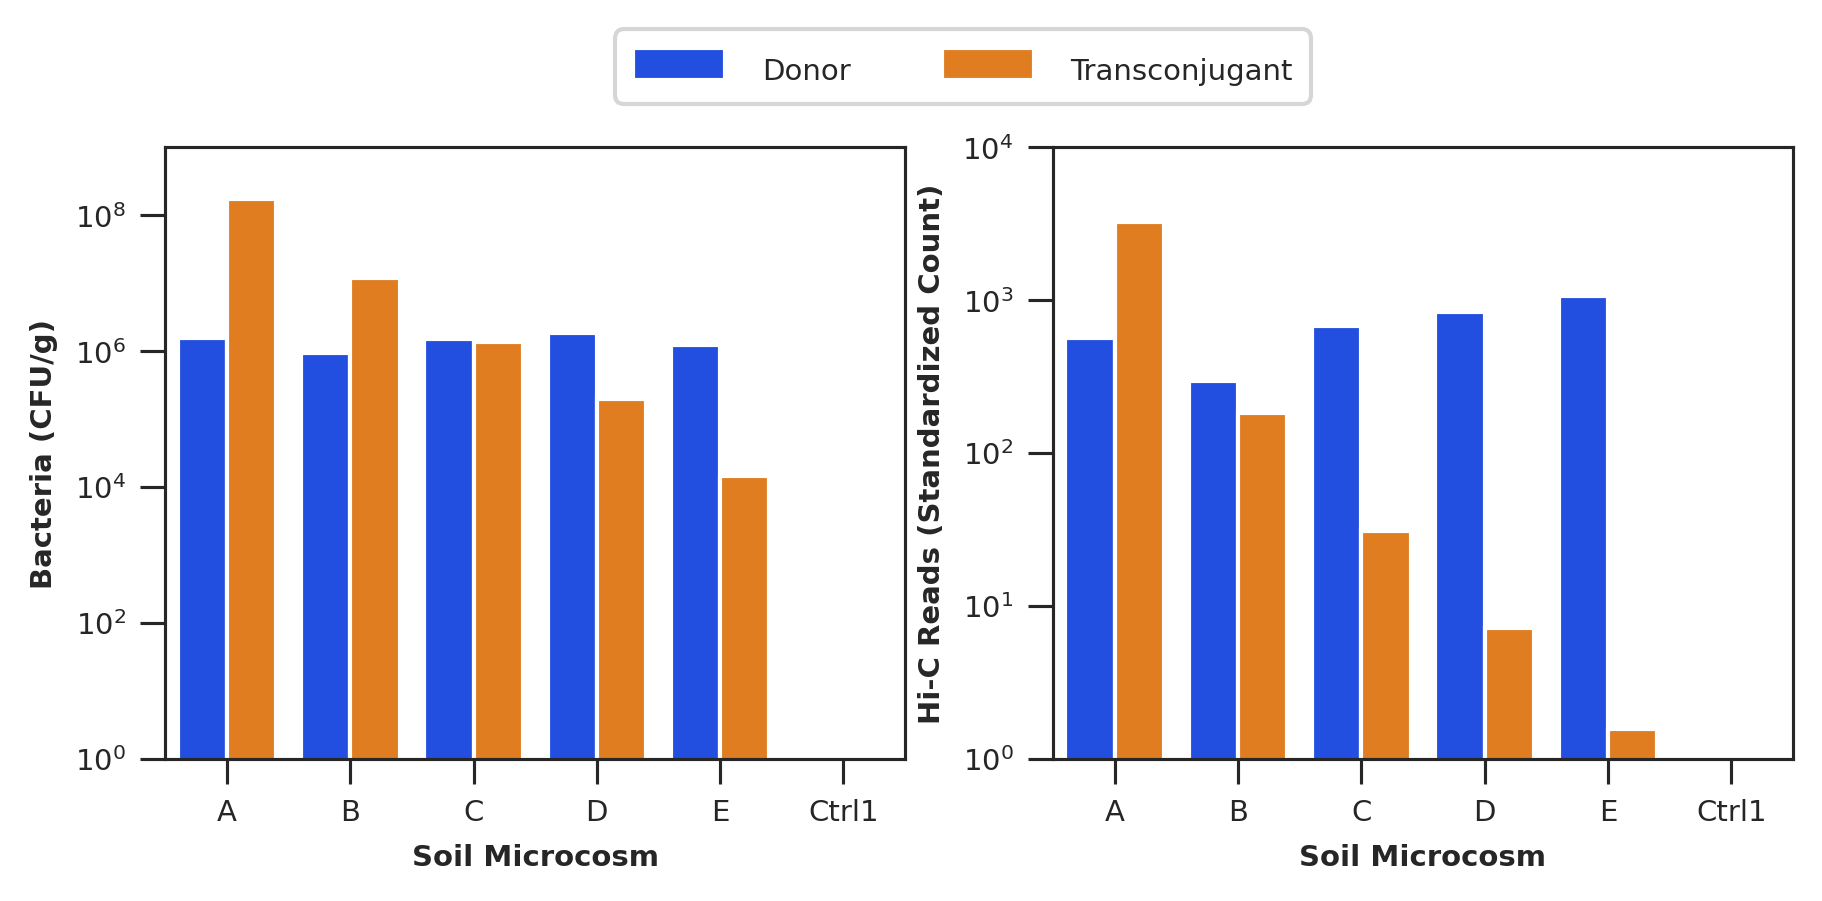

In [896]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/')
figure1data = all_data.loc[(all_data['type']=='Hi-C') & 
                           (all_data['Hi-C link']!='pB10-pB10')]

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
#Figure 1
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,2.7), dpi=300)
sns.set(style='ticks')


figure1data['plate_counts'] = [1.54e6, 9.51e5,1.52e6,1.87e6,1.24e6,0,1.73e8,1.18e7,1.37e6,1.94e5,1.44e4,0]
#figure1data['plate_counts'] = [7.8e4, 1.17e5,1.40e5,4.67e5,3.11e5,0,1.12e7,6.83e5,5.55e4,2.66e4,1.05e3,0]
figure1data['bacteria'] = ['Donor']*6 + ['Transconjugant']*6
sns.barplot(data = figure1data, x='Index', y='plate_counts', 
                      hue='bacteria', palette = 'bright', ax=ax1)
ax1.set_yscale('log')
ax1.set_ylabel('Bacteria (CFU/g)', fontsize=7, fontweight='bold')
ax1.set_xlabel('Soil Microcosm', fontsize=7, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_ylim(1, 1000000000)
plt.minorticks_off()
ax1.legend(loc='upper right', bbox_to_anchor=(1.58,1.23), ncol=2)
plt.setp(ax1.get_legend().get_texts(), fontsize='7') 
plt.setp(ax1.get_legend().get_title(), fontsize='7') 
plt.setp(ax1.spines.values(), linewidth=.75)
ax1.xaxis.set_tick_params(width=.75)
ax1.yaxis.set_tick_params(width=.75)

sns.barplot(data = figure1data, x='Index', y='count', 
            hue='Hi-C link', palette = 'bright', ax=ax2)
ax2.set_yscale('log')
ax2.set_ylabel('Hi-C Reads (Standardized Count)', fontsize=7, fontweight='bold')
ax2.set_xlabel('Soil Microcosm', fontsize=7, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.set_ylim(1, 10000)
plt.minorticks_off()
plt.legend('', frameon=False)
plt.setp(ax2.get_legend().get_texts(), fontsize='7') 
plt.setp(ax2.get_legend().get_title(), fontsize='7') 
plt.setp(ax2.spines.values(), linewidth=.75)
ax2.xaxis.set_tick_params(width=.75)
ax2.yaxis.set_tick_params(width=.75)

plt.savefig('Fig2.pdf', bbox_inches='tight', dpi=300)
plt.savefig('Fig2.png', bbox_inches='tight', dpi=300)

In [644]:
plate_table = all_data[(all_data['type']=='Hi-C+')&(all_data['Hi-C link']!='pB10-pB10')]
plate_table['plate_counts'] = [9.51e5,1.52e6,1.87e6,1.24e6,9.27e5,0,0,1.18e7,1.37e6,1.94e5,1.44e4,1.32e3,0,0]
plate_table['bacteria'] = ['Donor']*7 + ['Transconjugant']*7
plate_table

/mnt/ceph/cast9836/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/ceph/cast9836/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Index,Hi-C link,count,type,plate_counts,bacteria
7,B,Ecoli-pB10,221839.267754,Hi-C+,951000.0,Donor
8,C,Ecoli-pB10,251378.663551,Hi-C+,1520000.0,Donor
9,D,Ecoli-pB10,535112.922463,Hi-C+,1870000.0,Donor
10,E,Ecoli-pB10,524340.758286,Hi-C+,1240000.0,Donor
11,F,Ecoli-pB10,602984.292750,Hi-C+,927000.0,Donor
12,Ctrl1,Ecoli-pB10,149.266632,Hi-C+,0.0,Donor
13,Ctrl2,Ecoli-pB10,0.000000,Hi-C+,0.0,Donor
14,B,Pputida-pB10,99683.481729,Hi-C+,11800000.0,Transconjugant
15,C,Pputida-pB10,10159.275907,Hi-C+,1370000.0,Transconjugant
16,D,Pputida-pB10,3111.223088,Hi-C+,194000.0,Transconjugant


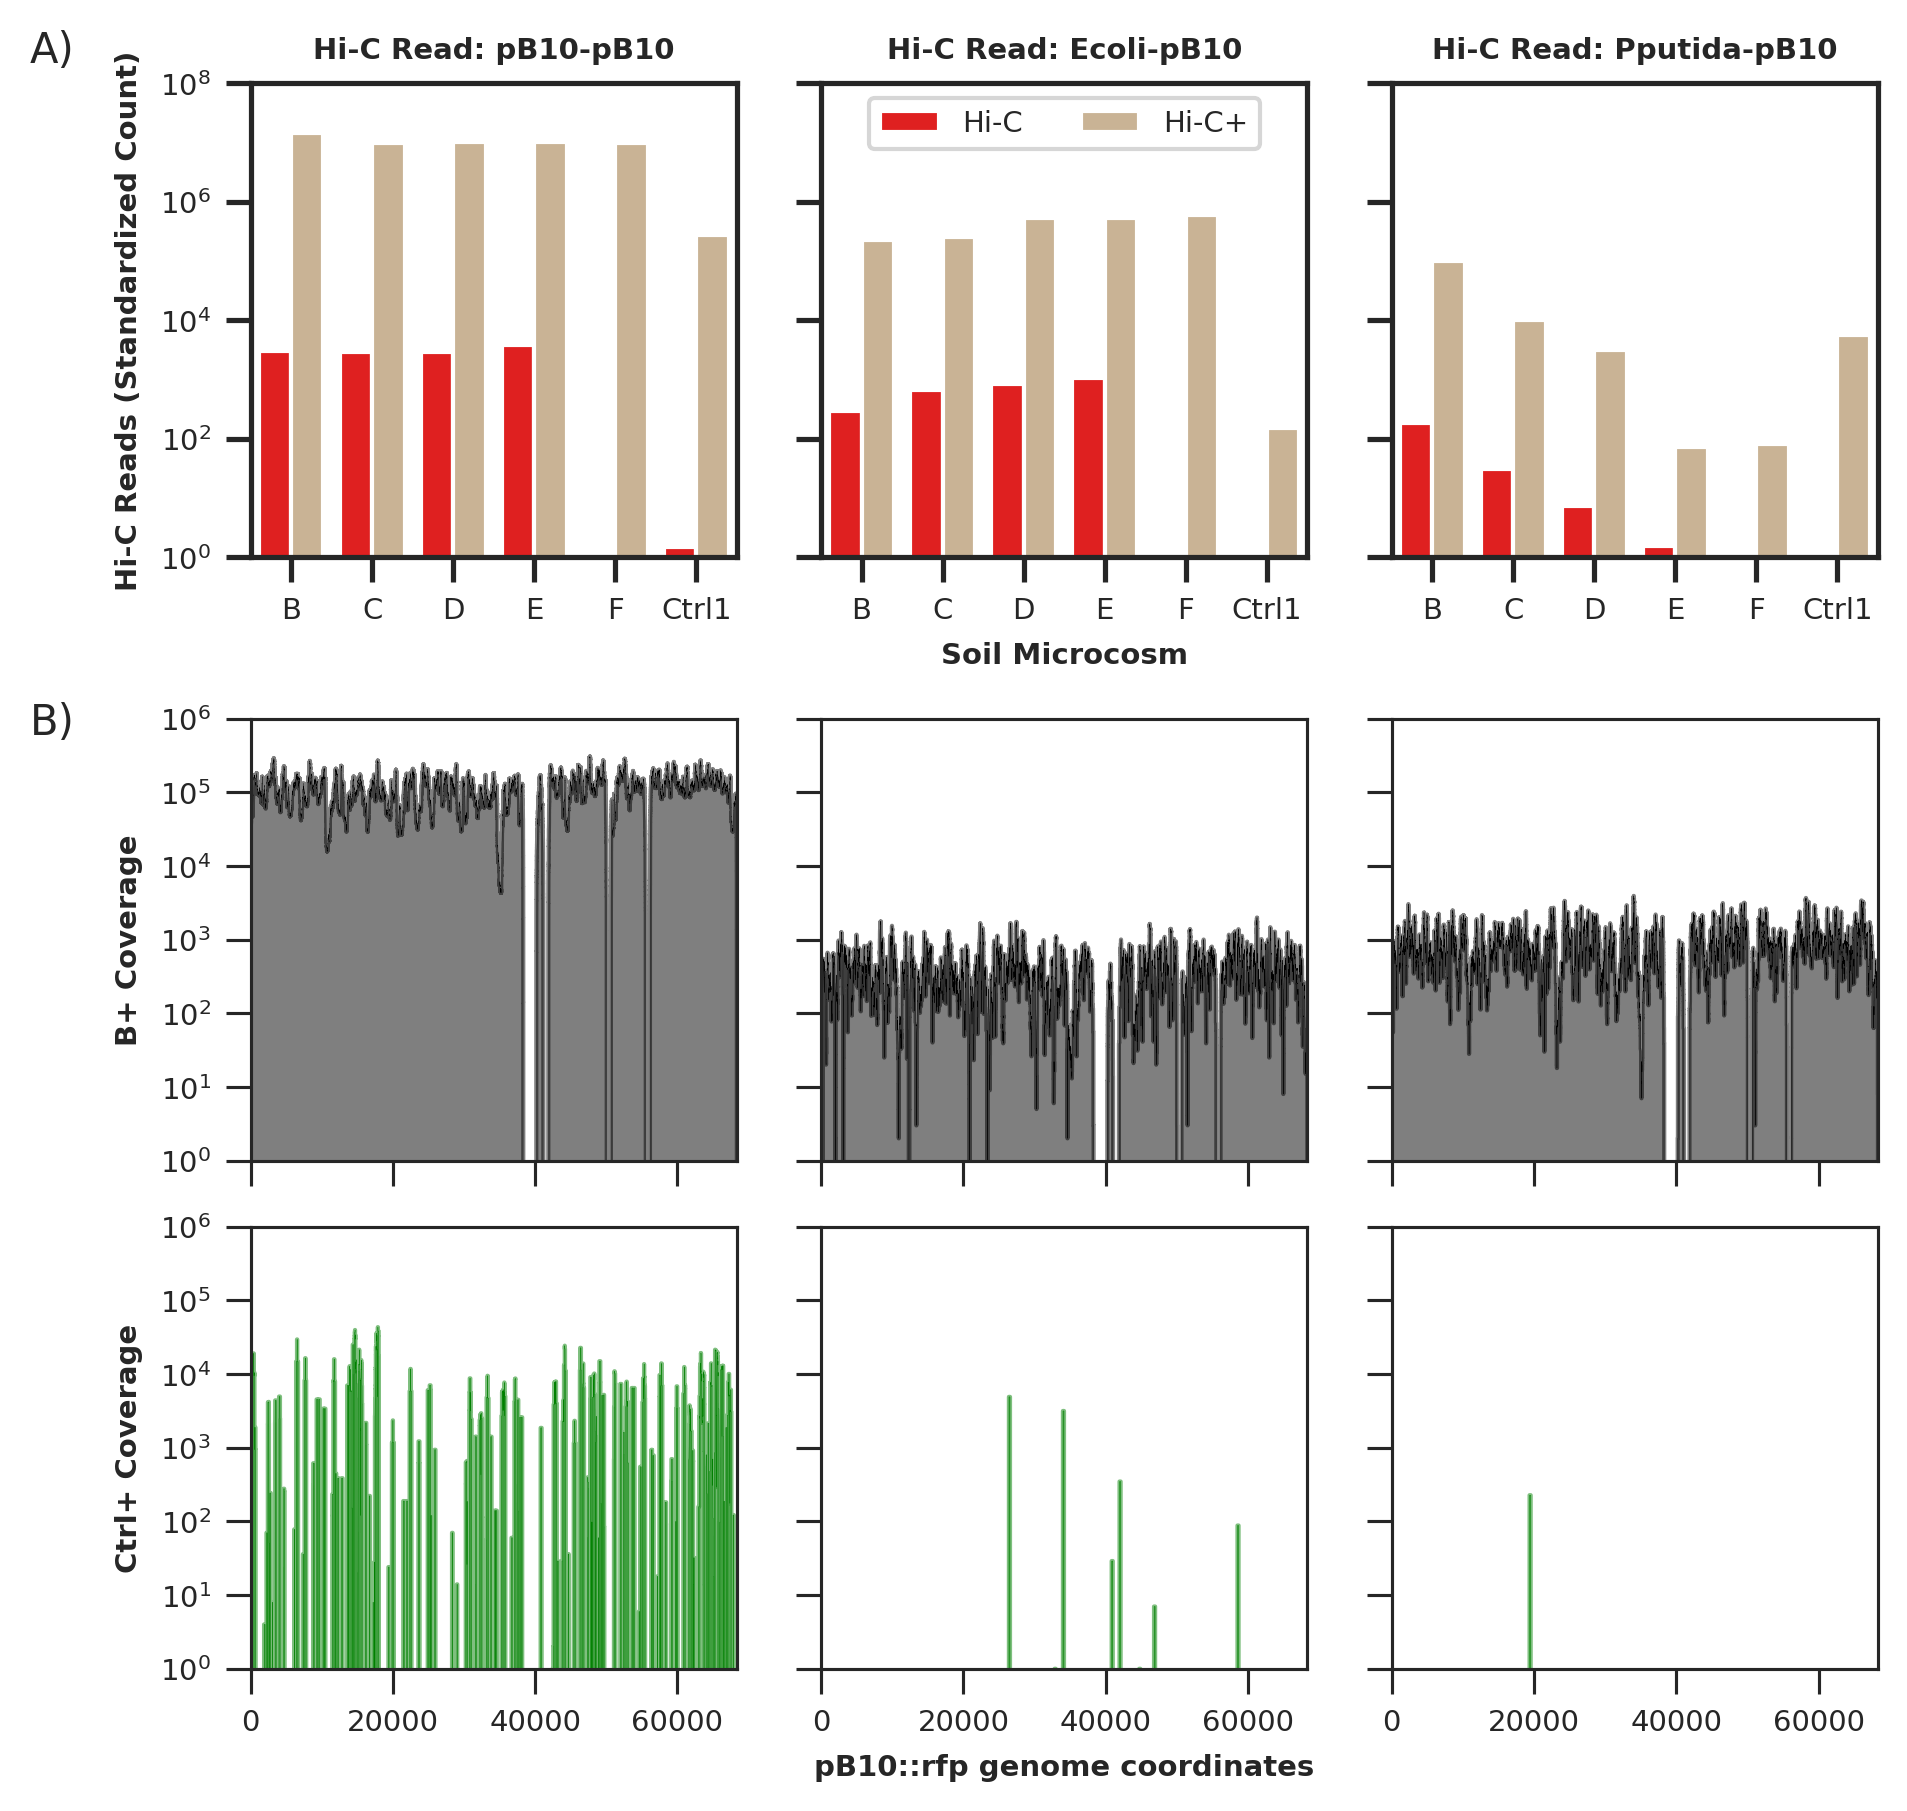

In [915]:
fig = plt.figure(figsize=(7, 7), dpi=300)
gs = fig3.add_gridspec(100, 100)

rc = {'font.size': 7.0, 'axes.labelsize': 7.0, 'axes.titlesize': 7.0, 'xtick.labelsize': 7.0,
      'ytick.labelsize': 7.0, 'legend.fontsize': 7.0, 'legend.title_fontsize': 7.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)

ax1 = fig.add_subplot(gs[:30,0:30])
ax2 = fig.add_subplot(gs[:30,35:65])
ax3 = fig.add_subplot(gs[:30,70:])
ax4 = fig.add_subplot(gs[40:68,0:30])
ax5 = fig.add_subplot(gs[40:68,35:65])
ax6 = fig.add_subplot(gs[40:68,70:])
ax7 = fig.add_subplot(gs[72:,0:30])
ax8 = fig.add_subplot(gs[72:,35:65])
ax9 = fig.add_subplot(gs[72:,70:])
plt.figtext(0.02, 0.89, 'A)', fontsize=10)
plt.figtext(0.02, 0.57, 'B)', fontsize=10)
all_data = all_data[all_data['Index']!='Ctrl2']
#----------------------------------- panel A -----------------------------------------------
sns.barplot(data = all_data[all_data['Hi-C link']=='pB10-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax1, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl1']).set(yscale='log')
ax1.set_ylim(1, 100000000)
ax1.set_ylabel('Hi-C Reads (Standardized Count)', fontsize=7, fontweight='bold')
ax1.set(xlabel=None)
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Hi-C Read: pB10-pB10', fontsize=7, fontweight='bold')
ax1.legend('',frameon=False)

sns.barplot(data = all_data[all_data['Hi-C link']=='Ecoli-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax2, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl1']).set(yscale='log')
ax2.set_xlabel('Soil Microcosm', fontsize=7, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.legend(loc='upper center', ncol=2)
ax2.set(ylabel=None)
ax2.set_title('Hi-C Read: Ecoli-pB10', fontsize=7, fontweight='bold')
ax2.set_ylim(1, 100000000)
ax2.tick_params(axis='y', label1On=False)
ax2.yaxis.set_ticklabels([])

sns.barplot(data = all_data[all_data['Hi-C link']=='Pputida-pB10'], x='Index', y='count', 
            hue='type', palette={'Hi-C':'red', 'Hi-C+':'tan'}, ax=ax3, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl1']).set(yscale='log')
ax3.tick_params(axis='both', which='major', labelsize=7)
ax3.set(ylabel=None)
ax3.set(xlabel=None)
ax3.set_title('Hi-C Read: Pputida-pB10', fontsize=7, fontweight='bold')
ax3.set_ylim(1, 100000000)
ax3.tick_params(axis='y', label1On=False)
ax3.yaxis.set_ticklabels([])
ax3.legend('',frameon=False)

#--------------------------------------panel B------------------------------------------------
ax4.plot(x, Bplus_all[1][1],
        color='black',
        linewidth=.05)
ax4.fill_between(x, Bplus_all[1][1], 0, color='black', alpha=.5)
ax4.set(yscale='log')
ax4.set_ylabel('B+ Coverage', fontsize=7, fontweight='bold')
ax4.tick_params(axis='both', which='major', labelsize=7)
ax4.autoscale(enable=True, axis='x', tight=True)
ax4.margins(y=0)
plt.setp(ax4.spines.values(), linewidth=.75)
ax4.xaxis.set_tick_params(width=.75)
ax4.yaxis.set_tick_params(width=.75)
ax4.set_ylim(1, 1000000)
ax4.xaxis.set_ticklabels([])
ax4.minorticks_off()

ax5.plot(x, Bplus_all[1][0],
        color='black',
        linewidth=.1)
ax5.fill_between(x, Bplus_all[1][0], 0, color='black', alpha=.5)
ax5.set(yscale='log')
ax5.tick_params(axis='both', which='major', labelsize=7)
ax5.autoscale(enable=True, axis='x', tight=True)
ax5.margins(y=0)
plt.setp(ax5.spines.values(), linewidth=.75)
ax5.xaxis.set_tick_params(width=.75)
ax5.yaxis.set_tick_params(width=.75) 
ax5.set_ylim(1, 1000000)
ax5.yaxis.set_ticklabels([])
ax5.minorticks_off()
ax5.xaxis.set_ticklabels([])


ax6.plot(x, Bplus_all[1][2],
        color='black',
        linewidth=.1)
ax6.fill_between(x, Bplus_all[1][2], 0, color='black', alpha=.5)
ax6.set(yscale='log')
ax6.tick_params(axis='both', which='major', labelsize=7)
ax6.autoscale(enable=True, axis='x', tight=True)
ax6.margins(y=0)
plt.setp(ax6.spines.values(), linewidth=.75)
ax6.xaxis.set_tick_params(width=.75)
ax6.yaxis.set_tick_params(width=.75)
ax6.set_ylim(1, 1000000)
ax6.yaxis.set_ticklabels([])
ax6.minorticks_off()
ax6.xaxis.set_ticklabels([])


ax7.plot(x, ctrl1plus_all[1][1],
        color='green',
        linewidth=.1,)
ax7.fill_between(x, ctrl1plus_all[1][1], 0, color='green', alpha=.5)
ax7.set_ylabel('Ctrl+ Coverage', fontsize=7, fontweight='bold')
ax7.set(yscale='log')
ax7.tick_params(axis='both', which='major', labelsize=7)
ax7.autoscale(enable=True, axis='x', tight=True)
ax7.margins(y=0)
plt.setp(ax7.spines.values(), linewidth=.75)
ax7.xaxis.set_tick_params(width=.75)
ax7.yaxis.set_tick_params(width=.75) 
ax7.set_ylim(1, 1000000)
ax7.minorticks_off()


ax8.plot(x, ctrl1plus_all[1][0],
        color='green',
        linewidth=.1,)
ax8.fill_between(x, ctrl1plus_all[1][0], 0, color='green', alpha=.5)
ax8.set(yscale='log')
ax8.tick_params(axis='both', which='major', labelsize=7)
ax8.autoscale(enable=True, axis='x', tight=True)
ax8.margins(y=0)
plt.setp(ax8.spines.values(), linewidth=.75)
ax8.xaxis.set_tick_params(width=.75)
ax8.yaxis.set_tick_params(width=.75)
ax8.set_ylim(1, 1000000)
ax8.set_xlabel('pB10::rfp genome coordinates', fontsize=7, fontweight='bold')
ax8.yaxis.set_ticklabels([])
ax8.minorticks_off()

ax9.plot(x, ctrl1plus_all[1][2],
        color='green',
        linewidth=.1,)
ax9.fill_between(x, ctrl1plus_all[1][2], 0, color='green', alpha=.5)
ax9.set(yscale='log')
ax9.tick_params(axis='both', which='major', labelsize=7)
ax9.autoscale(enable=True, axis='x', tight=True)
ax9.margins(y=0)
plt.setp(ax9.spines.values(), linewidth=.75)
ax9.xaxis.set_tick_params(width=.75)
ax9.yaxis.set_tick_params(width=.75)
ax9.set_ylim(1, 1000000)
ax9.yaxis.set_ticklabels([])
ax9.minorticks_off()

plt.savefig('Fig3.pdf', bbox_inches='tight', dpi=300)
plt.savefig('Fig3.png', bbox_inches='tight', dpi=300)

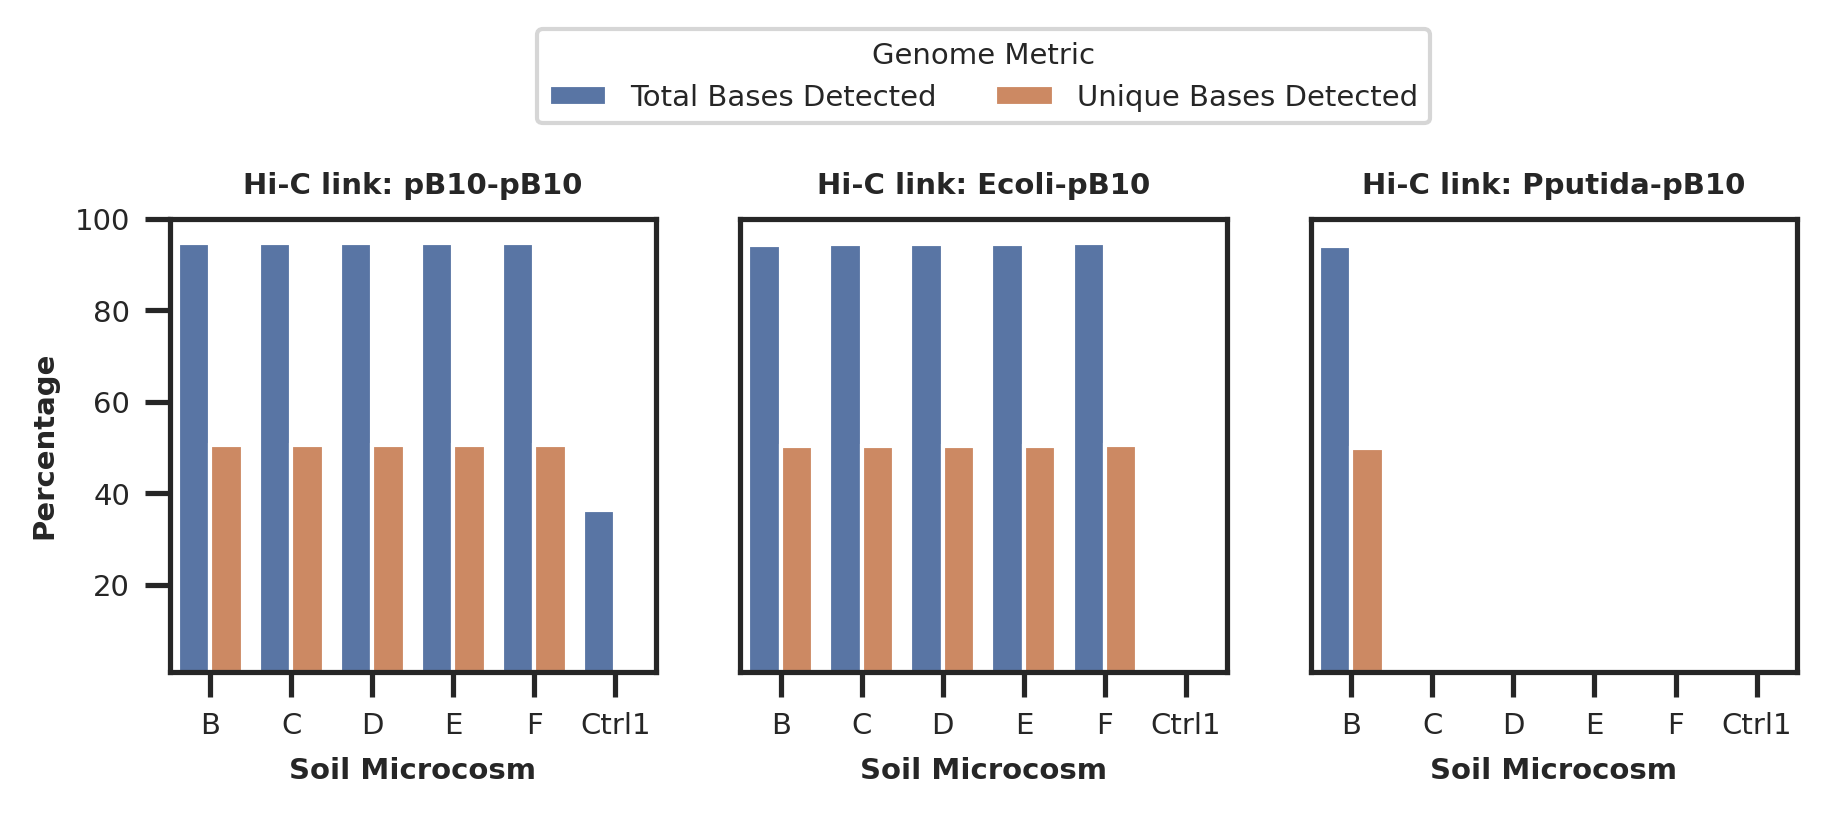

In [911]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/')
libs = [Bplus_all, Cplus_all, Dplus_all, Eplus_all, Fplus_all, ctrl1plus_all]
indexes = ['B', 'C', 'D', 'E', 'F', 'Ctrl1']

plot_cov = pd.DataFrame()

def unique_positions(ctrl, pb10):
    unique = []
    for i, j in zip(ctrl, pb10):
        if i == 0 and j > 0:
            unique.append(1)
        else:
            unique.append(0)
    return(unique)

for i in range(len(libs)):
    all_ctrl1 = list(map(add,ctrl1plus_all[1][0],ctrl1plus_all[1][1]))
    all_ctrl2 = list(map(add, all_ctrl1, ctrl1plus_all[1][2]))
    all_ctrl3 = list(map(add, all_ctrl2, ctrl2plus_all[1][0]))
    all_ctrl4 = list(map(add, all_ctrl3, ctrl2plus_all[1][1]))
    all_ctrl = list(map(add, all_ctrl4, ctrl2plus_all[1][2]))
    
    df1 = pd.DataFrame.from_dict({'covered_bases':np.count_nonzero(libs[i][1][0]),
                                  'unique_bases':np.count_nonzero(unique_positions(all_ctrl, libs[i][1][0])),
                                  'percent_detected':(np.count_nonzero(libs[i][1][0])/len(libs[i][1][0])*100),
                                  'link':['Pputida-pB10']})
    df2 = pd.DataFrame.from_dict({'covered_bases':np.count_nonzero(libs[i][1][1]),
                                  'unique_bases':np.count_nonzero(unique_positions(all_ctrl, libs[i][1][1])),
                                  'percent_detected':(np.count_nonzero(libs[i][1][1])/len(libs[i][1][1])*100),
                                  'link':['pB10-pB10']})
    df3 = pd.DataFrame.from_dict({'covered_bases':np.count_nonzero(libs[i][1][2]), 
                                  'unique_bases':np.count_nonzero(unique_positions(all_ctrl, libs[i][1][2])),
                                  'percent_detected':(np.count_nonzero(libs[i][1][2])/len(libs[i][1][2])*100),
                                  'link':['Ecoli-pB10']})
    comp_df = pd.concat([df2, df3,df1])
    comp_df['Indexes'] = indexes[i]
    plot_cov = pd.concat([plot_cov, comp_df])
plot_cov['percent_unique'] = plot_cov['unique_bases']/len(Bplus_all[1][1])*100
plot_ready = pd.DataFrame()
plot_ready['link'] = list(plot_cov['link'])*2
plot_ready['percent'] = list(plot_cov['percent_detected']) + list(plot_cov['percent_unique'])
plot_ready['Indexes'] = list(plot_cov['Indexes'])*2
plot_ready['type'] = ['Total Bases Detected']*18 + ['Unique Bases Detected']*18

fig = plt.figure(figsize=(7, 2), dpi=300)
gs = fig3.add_gridspec(100, 100)

rc = {'font.size': 7.0, 'axes.labelsize': 7.0, 'axes.titlesize': 7.0, 'xtick.labelsize': 7.0,
      'ytick.labelsize': 7.0, 'legend.fontsize': 7.0, 'legend.title_fontsize': 7.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)

ax1 = fig.add_subplot(gs[:,0:30])
ax2 = fig.add_subplot(gs[:,35:65])
ax3 = fig.add_subplot(gs[:,70:])

#left panel --------------------------------------------------------------------------
sns.barplot(data = plot_ready[plot_ready['link']=='pB10-pB10'], x='Indexes', y='percent', 
            hue='type', ax=ax1, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl1'])
ax1.set_ylim(1, 100)
ax1.set_ylabel('Percentage', fontsize=7, fontweight='bold')
ax1.set_xlabel('Soil Microcosm', fontsize=7, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Hi-C link: pB10-pB10', fontsize=7, fontweight='bold')
ax1.legend('',frameon=False)


#center panel ----------------------------------------------------------------------------
sns.barplot(data = plot_ready[plot_ready['link']=='Ecoli-pB10'], x='Indexes', y='percent', 
            hue='type', ax=ax2, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl1'])
ax2.set_xlabel('Soil Microcosm', fontsize=7, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=7)
ax2.set(ylabel=None)
ax2.set_title('Hi-C link: Ecoli-pB10', fontsize=7, fontweight='bold')
ax2.set_ylim(1, 100)
ax2.tick_params(axis='y', label1On=False)
ax2.set_yticks([])
ax2.legend(loc='upper center', bbox_to_anchor=(.5,1.45), title='Genome Metric', ncol=2)


#right panel --------------------------------------------------------------------------------
sns.barplot(data = plot_ready[plot_ready['link']=='Pputida-pB10'], x='Indexes', y='percent', 
            hue='type', ax=ax3, 
            order=['B', 'C', 'D', 'E', 'F', 'Ctrl1'])
ax3.set_xlabel('Soil Microcosm', fontsize=7, fontweight='bold')
ax3.tick_params(axis='both', which='major', labelsize=7)
ax3.set(ylabel=None)
ax3.set_title('Hi-C link: Pputida-pB10', fontsize=7, fontweight='bold')
ax3.set_ylim(1, 100)
ax3.tick_params(axis='y', label1On=False)
ax3.set_yticks([])
ax3.legend('',frameon=False)

#plt.savefig('Fig3.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('Fig3.png', bbox_inches='tight', dpi=300)

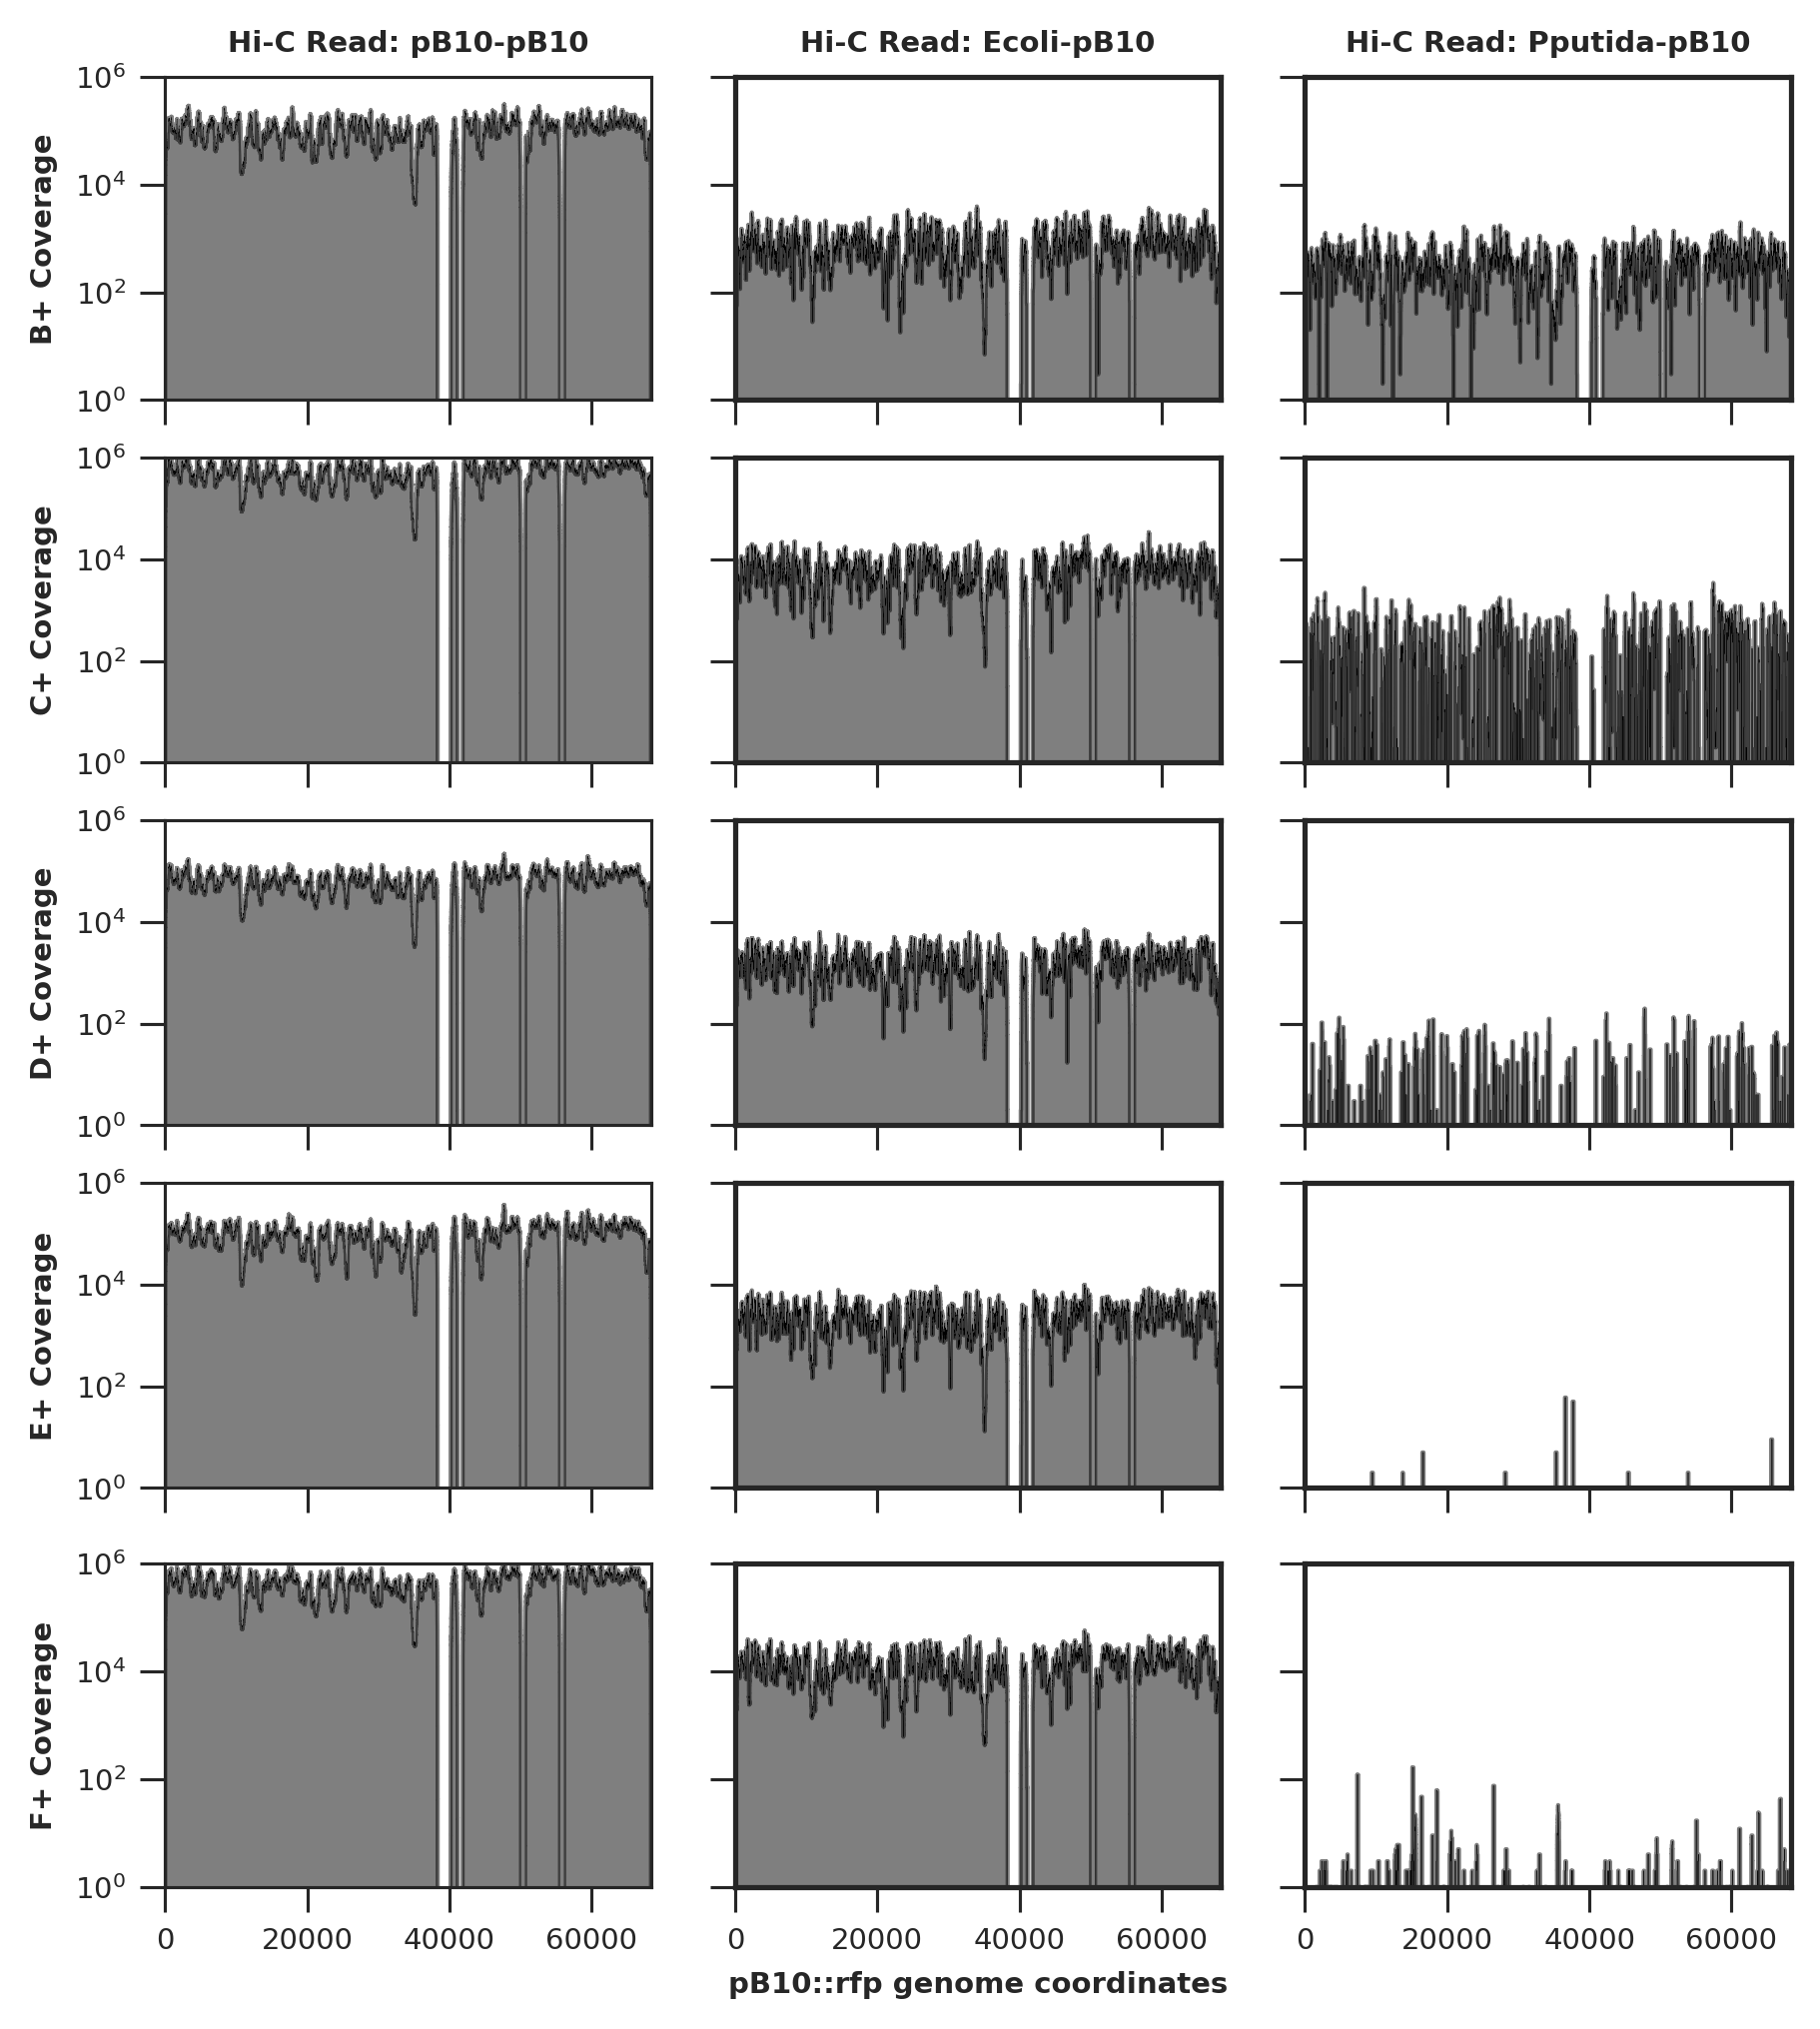

In [97]:
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/')

suppfig2 = plt.figure(figsize=(7, 8), dpi=300)
gs = suppfig2.add_gridspec(100, 100)

rc = {'font.size': 7.0, 'axes.labelsize': 7.0, 'axes.titlesize': 7.0, 'xtick.labelsize': 7.0,
      'ytick.labelsize': 7.0, 'legend.fontsize': 7.0, 'legend.title_fontsize': 7.0, "font.family": "Helvetica"}
sns.set(style='ticks', rc=rc)

ax1 = suppfig2.add_subplot(gs[:18,0:30])
ax2 = suppfig2.add_subplot(gs[:18,35:65])
ax3 = suppfig2.add_subplot(gs[:18,70:])

ax4 = suppfig2.add_subplot(gs[21:38,0:30])
ax5 = suppfig2.add_subplot(gs[21:38,35:65])
ax6 = suppfig2.add_subplot(gs[21:38,70:])

ax7 = suppfig2.add_subplot(gs[41:58,0:30])
ax8 = suppfig2.add_subplot(gs[41:58,35:65])
ax9 = suppfig2.add_subplot(gs[41:58,70:])

ax10 = suppfig2.add_subplot(gs[61:78,0:30])
ax11 = suppfig2.add_subplot(gs[61:78,35:65])
ax12 = suppfig2.add_subplot(gs[61:78,70:])

ax13 = suppfig2.add_subplot(gs[82:,0:30])
ax14 = suppfig2.add_subplot(gs[82:,35:65])
ax15 = suppfig2.add_subplot(gs[82:,70:])

def plot_coverage(library, ax1, ax2, ax3, xlabels='off'):
    x = list(range(len(library[1][0])))
    ax1.plot(x, library[1][1],
        color='black',
        linewidth=.05)
    ax1.fill_between(x, library[1][1], 0, color='black', alpha=.5)
    
    ax2.plot(x, library[1][2],
            color='black',
            linewidth=.1)    
    ax2.fill_between(x, library[1][2], 0, color='black', alpha=.5)
    
    ax3.plot(x, library[1][0],
            color='black',
            linewidth=.1)    
    ax3.fill_between(x, library[1][0], 0, color='black', alpha=.5)
    
    for ax in [ax1, ax2, ax3]:
        ax.set(yscale='log')
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.autoscale(enable=True, axis='x', tight=True)
        ax.margins(y=0)
        plt.setp(ax1.spines.values(), linewidth=.75)
        ax.xaxis.set_tick_params(width=.75)
        ax.yaxis.set_tick_params(width=.75)
        ax.set_ylim(1, 1000000)
        ax.minorticks_off()
        if xlabels == 'off':
            ax.xaxis.set_ticklabels([])

    ax2.yaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])

#make plots
plot_coverage(Bplus_all, ax1, ax2, ax3)
plot_coverage(Cplus_all, ax4, ax5, ax6)
plot_coverage(Dplus_all, ax7, ax8, ax9)
plot_coverage(Eplus_all, ax10, ax11, ax12)
plot_coverage(Fplus_all, ax13, ax14, ax15, 'On')

#add labels
ax1.set_ylabel('B+ Coverage', fontsize=7, fontweight='bold')
ax4.set_ylabel('C+ Coverage', fontsize=7, fontweight='bold')
ax7.set_ylabel('D+ Coverage', fontsize=7, fontweight='bold')
ax10.set_ylabel('E+ Coverage', fontsize=7, fontweight='bold')
ax13.set_ylabel('F+ Coverage', fontsize=7, fontweight='bold')
ax14.set_xlabel('pB10::rfp genome coordinates', fontsize=7, fontweight='bold')

ax1.set_title('Hi-C Read: pB10-pB10', fontsize=7, fontweight='bold')
ax2.set_title('Hi-C Read: Ecoli-pB10', fontsize=7, fontweight='bold')
ax3.set_title('Hi-C Read: Pputida-pB10', fontsize=7, fontweight='bold')

plt.savefig('supp2.pdf', bbox_inches='tight', dpi=300)
plt.savefig('supp2.png', bbox_inches='tight', dpi=300)

In [83]:
list(range(len(Bplus_all[1][0])))[-1]

68344

In [50]:
import os
os.chdir('/mnt/ceph/cast9836/00_projects/hic_targetcapture/06_output/figures/')

def extract_gene(loc_list):
    plasmid = SeqIO.read('../../04_ref_genomes/pB10__rfp putative.gb', 'genbank')
    location = []
    gene = []
    for loc in loc_list:
        temp = []
        temp_l = []
        for feature in plasmid.features:
            if feature.type == 'gene' and loc in feature:
                if 'gene' in feature.qualifiers.keys():
                    t = feature.qualifiers['gene']
                    temp.append(str(t)[2:-2])
                    temp_l.append(loc)
                else:
                    t = feature.qualifiers['standard_name']
                    temp.append(str(t)[2:-2])
                    temp_l.append(loc)
        if len(temp_l) == 1:
            location.append(temp_l[0])
            gene.append(str(temp[0]))
        elif len(temp_l) == 2:
            location.append(temp_l[0])
            gene.append(str(temp[0])+' and '+str(temp[1]))
    return([location, gene])

"""def conv_to_counts(linked_reads, loc_and_gene):
    no_gene = len(linked_reads) - (len(loc_and_gene[0]))
    all_genes = loc_and_gene[1]
    unique_genes = list(set(loc_and_gene[1]))
    apps = []
    for i in unique_genes:
        apps.append(all_genes.count(i))
    unique_genes.append('No gene')
    apps.append(no_gene)
    return(unique_genes, apps)"""

def conv_to_counts(loc_and_gene):
    all_genes = loc_and_gene[1]
    unique_genes = list(set(loc_and_gene[1]))
    apps = []
    for i in unique_genes:
        apps.append(all_genes.count(i))
    return(unique_genes, apps)

ctrl1_pb_pb_genes = extract_gene(ctrl1plus_all[2][1])
ctrl1_pb_ecoli_genes = extract_gene(ctrl1plus_all[2][2])
ctrl1_pb_pputida_genes = extract_gene(ctrl1plus_all[2][0])

ctrl1_pb_pb_counts = conv_to_counts(ctrl1_pb_pb_genes)
ctrl1_pb_ecoli_counts = conv_to_counts(ctrl1_pb_ecoli_genes)
ctrl1_pb_pputida_counts = conv_to_counts(ctrl1_pb_pputida_genes)

ctrl1_pb_pb_df = pd.DataFrame(list(zip(ctrl1_pb_pb_counts[0],ctrl1_pb_pb_counts[1])), columns=[1,2]).explode(2).reset_index(drop=True).add_prefix('column')
ctrl1_pb_ecoli_df = pd.DataFrame(list(zip(ctrl1_pb_ecoli_counts[0],ctrl1_pb_ecoli_counts[1])), columns=[1,2]).explode(2).reset_index(drop=True).add_prefix('column')
ctrl1_pb_pputida_df = pd.DataFrame(list(zip(ctrl1_pb_pputida_counts[0],ctrl1_pb_pputida_counts[1])), columns=[1,2]).explode(2).reset_index(drop=True).add_prefix('column')

ctrl1_pb_pb_df.loc[54] = ['tnpA', 23822+18468]
ctrl1_pb_pb_df.drop([2,3], inplace=True)
ctrl1_pb_pb_df.rename(columns={'column1':'Gene', 'column2':'pB10-pB10'}, inplace=True)
ctrl1_pb_pputida_df.loc[0] = ['tnpA', 88]
ctrl1_pb_pputida_df.rename(columns={'column1':'Gene', 'column2':'Pputida-pB10'}, inplace=True)
ctrl1_pb_ecoli_df.rename(columns={'column1':'Gene', 'column2':'Ecoli-pB10'}, inplace=True)

/opt/modules/devel/python/3.6.7/lib/python3.6/site-packages/Bio/GenBank/Scanner.py:1368: BiopythonParserWarning: Attempting to parse malformed locus line:
'LOCUS       pB10::rfp_putative       68345 bp    DNA     circular CON 06-JUN-2018\n'
Found locus 'pB10::rfp_putative' size '68345' residue_type 'DNA'
Some fields may be wrong.
  BiopythonParserWarning)


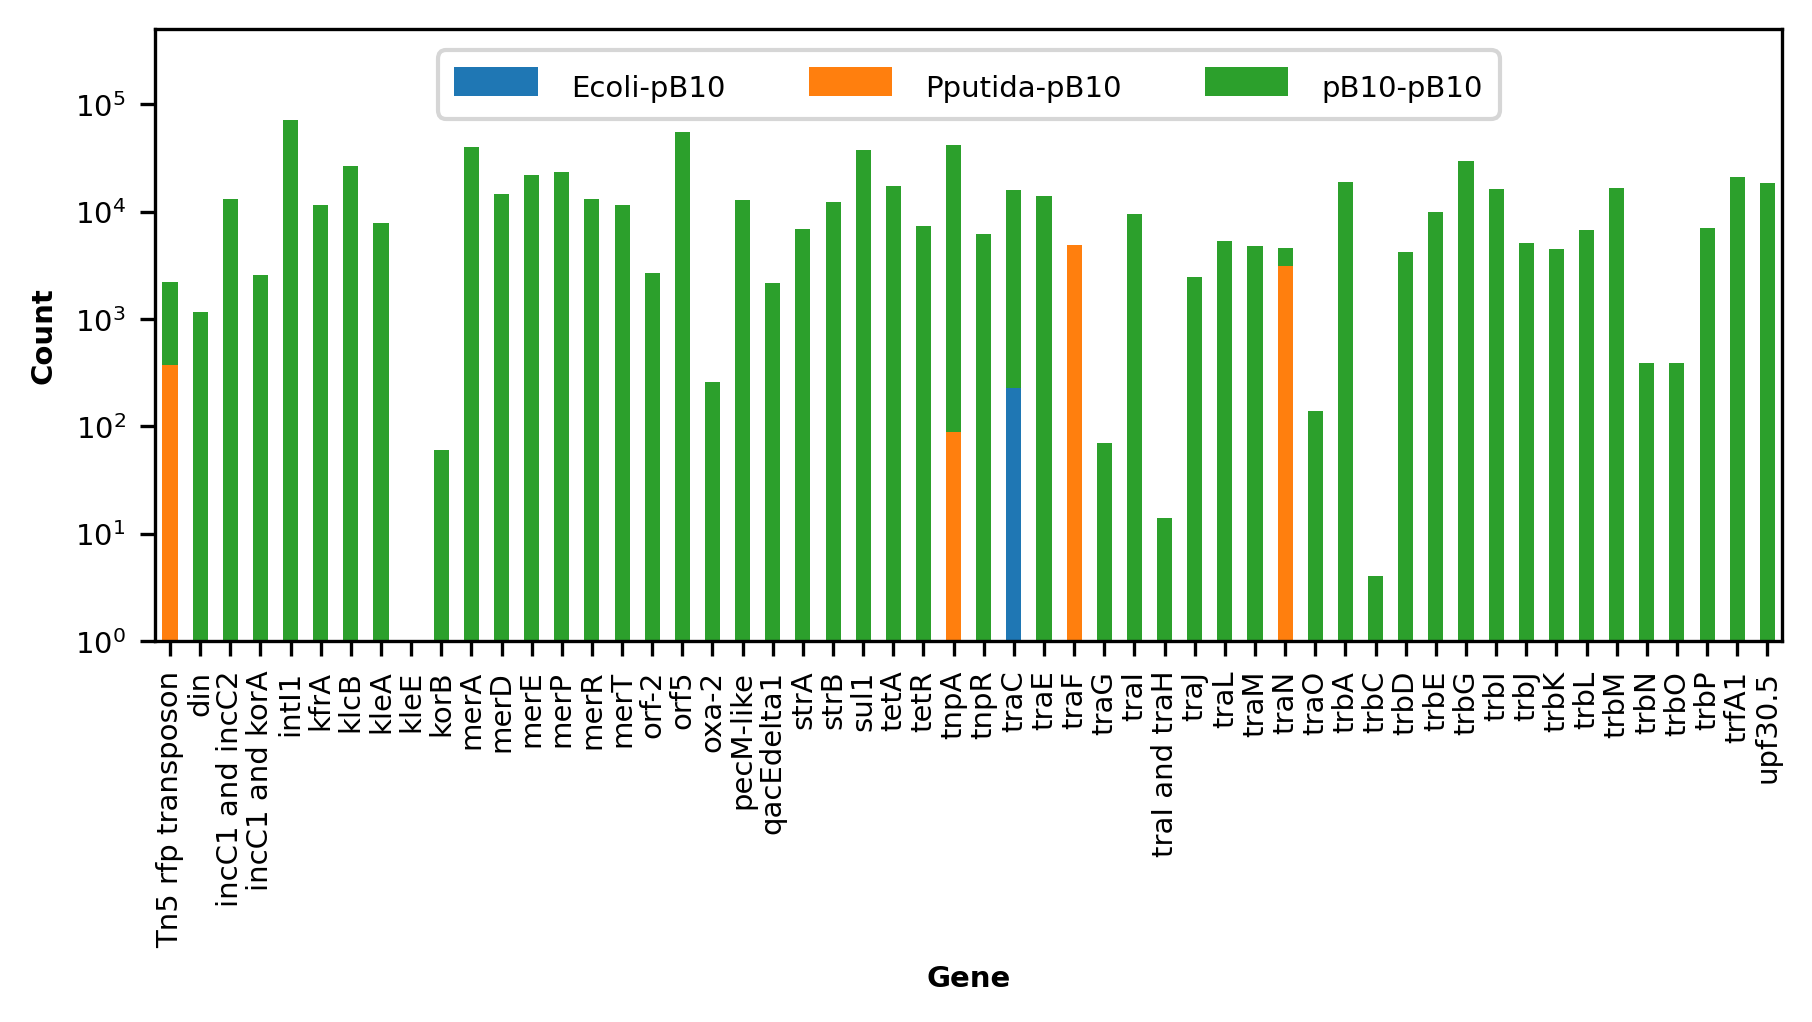

In [75]:
combined_df = ctrl1_pb_ecoli_df.merge(ctrl1_pb_pputida_df, on='Gene', how='outer').merge(ctrl1_pb_pb_df, on='Gene', how='outer')
combined_df.fillna(0, inplace=True)
combined_df = combined_df.sort_values(by=['Gene']).set_index('Gene')

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})

#Supplementary figure
fig, ax1 = plt.subplots(figsize=(7,2.7), dpi=300)
combined_df.plot.bar(stacked=True, ax=ax1)
ax1.set(yscale='log')
ax1.set_ylabel('Count', fontsize=7, fontweight='bold')
ax1.set_xlabel('Gene', fontsize=7, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.legend(loc='upper center', ncol=3)
plt.setp(ax1.get_legend().get_texts(), fontsize='7')
ax1.set_ylim(1, 500000)
ax1.minorticks_off()

plt.savefig('supp3.pdf', bbox_inches='tight', dpi=300)
plt.savefig('supp3.png', bbox_inches='tight', dpi=300)

In [69]:
ctrl1_pb_pputida_df

,Gene,Pputida-pB10
0,tnpA,88
1,traN,3158
2,traF,4905
3,Tn5 rfp transposon,377
4,traM,1


In [68]:
combined_df

,Ecoli-pB10,Pputida-pB10,pB10-pB10
Gene,,,
Tn5 rfp transposon,0.0,377.0,1862.0
din,0.0,0.0,1161.0
incC1 and incC2,0.0,0.0,13202.0
incC1 and korA,0.0,0.0,2592.0
intI1,0.0,0.0,71929.0
kfrA,0.0,0.0,11574.0
klcB,0.0,0.0,26579.0
kleA,0.0,0.0,7940.0
kleE,0.0,0.0,1.0


In [36]:
ctrl1_pb_pputida_df.loc[0] = ['tnpA', 88]
ctrl1_pb_pputida_df

,column1,column2
0,tnpA,88
1,traN,3158
2,traF,4905
3,Tn5 rfp transposon,377
4,traM,1


In [ ]:
ecoli_gene = {735595: 'ybfO', 'blast search detected sequence in salmonells sp hnk130, shigella flexneri, and escherichia genus'
              739397: 'ybgA, DUF1722 domain-containing protein YbgA, NP_415235.1, same with this one. protein found in shigella and escherichia'}

pputida_genes = {5024355: 'PP_RS22990, PLP-dependent aminotransferase family protein, WP_029886623.1' 'no sim on plasmids', 
                 1818628: 'PP_RS08360, peptidoglycan DD-metalloendopeptidase family protein, WP_049588177.1' 'Pseudomonas sp. TMW 2.1634 plasmid pL21634-2, complete sequence', 
                 5689795: 'pilH, twitching motility response regulator PilH, WP_003249327.1', 'no sim', 
                 426631: 'PP_RS01860, TonB-dependent siderophore receptor, WP_010951702.1' 'no sim', 
                 595884: 'PP_RS02685, ABC transporter permease, WP_010951795.1', 
                 3405935+3405944: 'PP_RS15610, methylated-DNA--[protein]-cysteine S-methyltransferase, WP_010953916.1', 
                 6148755, 'PP_RS28095, heavy metal translocating P-type ATPase' 
                 4054047, 'PP_RS18565, NAD(P)/FAD-dependent oxidoreductase, WP_010954426.1'}

In [1]:
ctrl1plus_all[1][1]

NameError: name 'ctrl1plus_all' is not defined